In [64]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from utils import LOG_DIR
from typing import Dict

def parse_log_file(file_path):
    # Define the patterns to search for
    peak_activation_memory_pattern = r"Peak Activation Memory: (.+?) Bytes"
    total_memory_pattern = r"Total Memory: (.+?) Bytes"
    avg_forward_time_pattern = r"Average Forward Time: (.+?) sec"
    avg_backward_time_pattern = r"Average Backward Time: (.+?) sec"
    throughput_pattern = r"Throughput: (.+?) samples/sec"
    max_memory_device_pattern = r"(cuda:\d+): (.+?) Bytes"

    # Dictionary to store the extracted information
    data = {
        "peak_activation_memory_mib": None,
        "total_memory_mib": None,
        "average_forward_time_sec": None,
        "average_backward_time_sec": None,
        "throughput_samples_per_sec": None,
        "max_memory_per_device_mib": {}
    }

    

    def convert_data(data_str):
        return ''.join(str(data_str).split(','))
    
    def bytes_to_mib(bytes_str):
        # Convert bytes to MiB
        bytes_str = convert_data(bytes_str)
        return round(int(bytes_str) / (1024**2), 2)

    with open(file_path, 'r') as file:
        for line in file:
            # Check for each pattern and extract data
            if match := re.search(peak_activation_memory_pattern, line):
                data["peak_activation_memory_mib"] = bytes_to_mib(match.group(1))
            elif match := re.search(total_memory_pattern, line):
                data["total_memory_mib"] = bytes_to_mib(match.group(1))
            elif match := re.search(avg_forward_time_pattern, line):
                data["average_forward_time_sec"] = float(match.group(1))
            elif match := re.search(avg_backward_time_pattern, line):
                data["average_backward_time_sec"] = float(match.group(1))
            elif match := re.search(throughput_pattern, line):
                data["throughput_samples_per_sec"] = float(match.group(1))
            elif match := re.search(max_memory_device_pattern, line):
                device, memory_bytes = match.groups()
                data["max_memory_per_device_mib"][device] = bytes_to_mib(memory_bytes)

    return data

def print_dict(data: Dict):
    for key, value in data.items():
        print(f"{key}: {value}")


In [65]:
''.join('502,947,976'.split(','))

'502947976'

In [66]:
# get all file names under DATA_DIR
expr_data = {}
file_names = os.listdir(LOG_DIR)
for file_name in file_names:
    if file_name.endswith(".log"):
        file_path = os.path.join(LOG_DIR, file_name)
        data = parse_log_file(file_path)
        expr_data[file_name[:-4]] = data

In [67]:
def args_to_exprname(
    num_partition: int,
    num_microbatch: int,
    checkpoint_enabled: bool,
    use_torchgpipe: bool
):
    if num_partition > 0:
        return (f'mem_expr_K{num_partition}_M{num_microbatch}_'
            f'{"check_" if checkpoint_enabled else ""}'
            f'{"torchgpipe" if use_torchgpipe else "self"}'
        )
    else:
        return 'baseline'

num_partitions = [1, 2, 4]
num_micro_batches = [1, 2, 4, 6, 8, 16, 20, 32, 64]
checkpoint_enabled = [True, False]
use_torchgpipe = [True, False]

### Baseline

In [68]:
expr_name = args_to_exprname(0, 1, False, False)
baseline = expr_data[expr_name]
print_dict(baseline)

peak_activation_memory_mib: 397.65
total_memory_mib: 996.0
average_forward_time_sec: 0.04
average_backward_time_sec: 0.022
throughput_samples_per_sec: 2053.667
max_memory_per_device_mib: {'cuda:0': 996.0}


## Memory 
Variables:
- partition plans
- number of microbatches
- checkpointing enabled

In [69]:
dict(zip([1], [2]))

{1: 2}

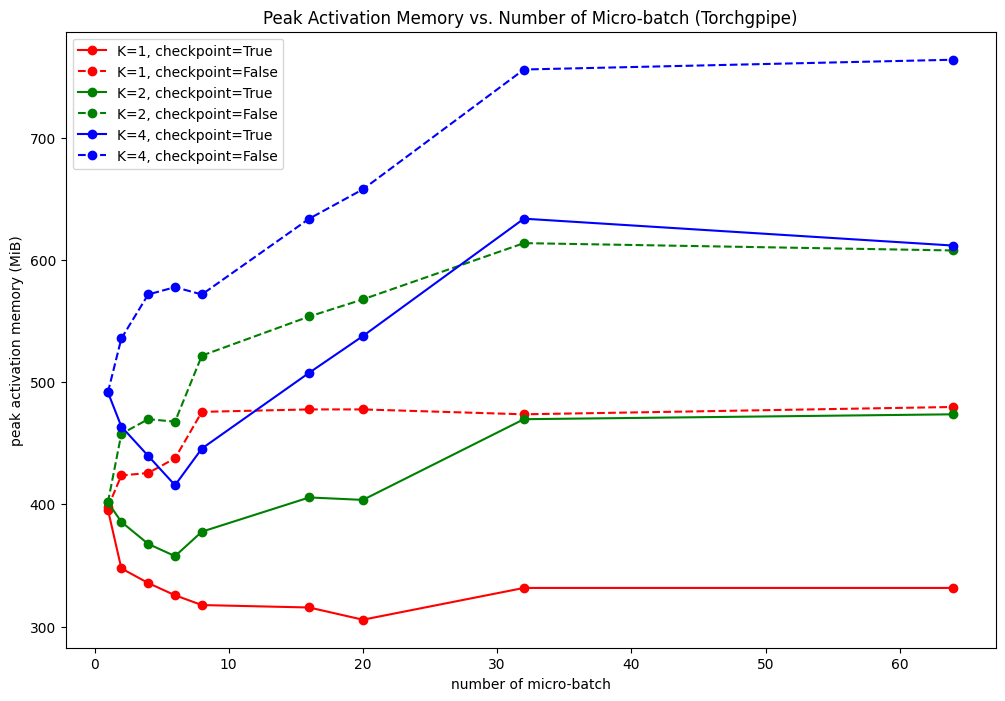

In [74]:
colors = dict(zip(num_partitions, ['r', 'g', 'b']))
linestyles = dict(zip(checkpoint_enabled, ['-', '--']))

fig = plt.figure(figsize=(12, 8))
for num_partition in num_partitions:
    for checkpoint in checkpoint_enabled:
        total_memories = []
        for num_micro_batch in num_micro_batches:
            expr_name = args_to_exprname(
                num_partition, num_micro_batch, checkpoint, use_torchgpipe=True
            )
            data = expr_data[expr_name]
            total_memories.append(data['peak_activation_memory_mib'])

        plt.plot(num_micro_batches, total_memories,
            color=colors[num_partition], linestyle=linestyles[checkpoint],
            label=f'K={num_partition}, checkpoint={checkpoint}',
            marker='o',
        )
        plt.xlabel('number of micro-batch')
        plt.ylabel('peak activation memory (MiB)')
        plt.title('Peak Activation Memory vs. Number of Micro-batch (Torchgpipe)')
        plt.legend()
plt.show()

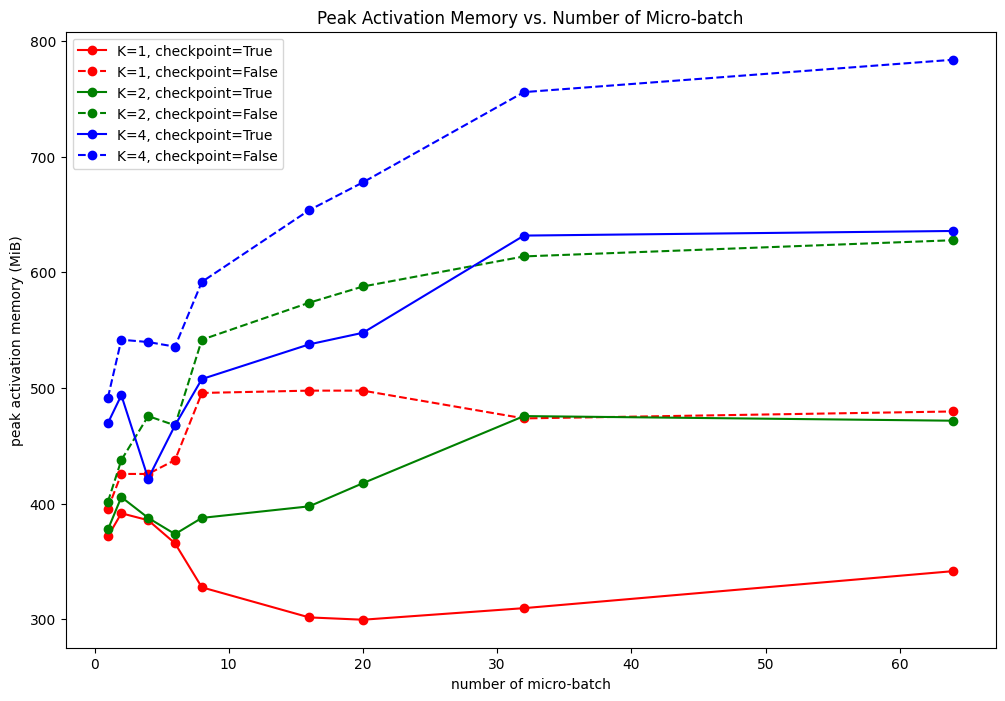

In [73]:
colors = dict(zip(num_partitions, ['r', 'g', 'b']))
linestyles = dict(zip(checkpoint_enabled, ['-', '--']))

fig = plt.figure(figsize=(12, 8))
for num_partition in num_partitions:
    for checkpoint in checkpoint_enabled:
        total_memories = []
        for num_micro_batch in num_micro_batches:
            expr_name = args_to_exprname(
                num_partition, num_micro_batch, checkpoint, use_torchgpipe=False
            )
            data = expr_data[expr_name]
            total_memories.append(data['peak_activation_memory_mib'])

        plt.plot(num_micro_batches, total_memories,
            color=colors[num_partition], linestyle=linestyles[checkpoint],
            label=f'K={num_partition}, checkpoint={checkpoint}',
            marker='o',
        )
        plt.xlabel('number of micro-batch')
        plt.ylabel('peak activation memory (MiB)')
        plt.title('Peak Activation Memory vs. Number of Micro-batch')
        plt.legend()
plt.show()

## Efficiency
- fixed: no checkpointing, architecture (`amoebanetd(num_classes=1000,  num_layers=18,  num_filters=256)`), 
- independent variables: number of partitions (n) and number of microbatches (m)
- dependent variables to observe: throughput speed-up rate compared to no parallelism

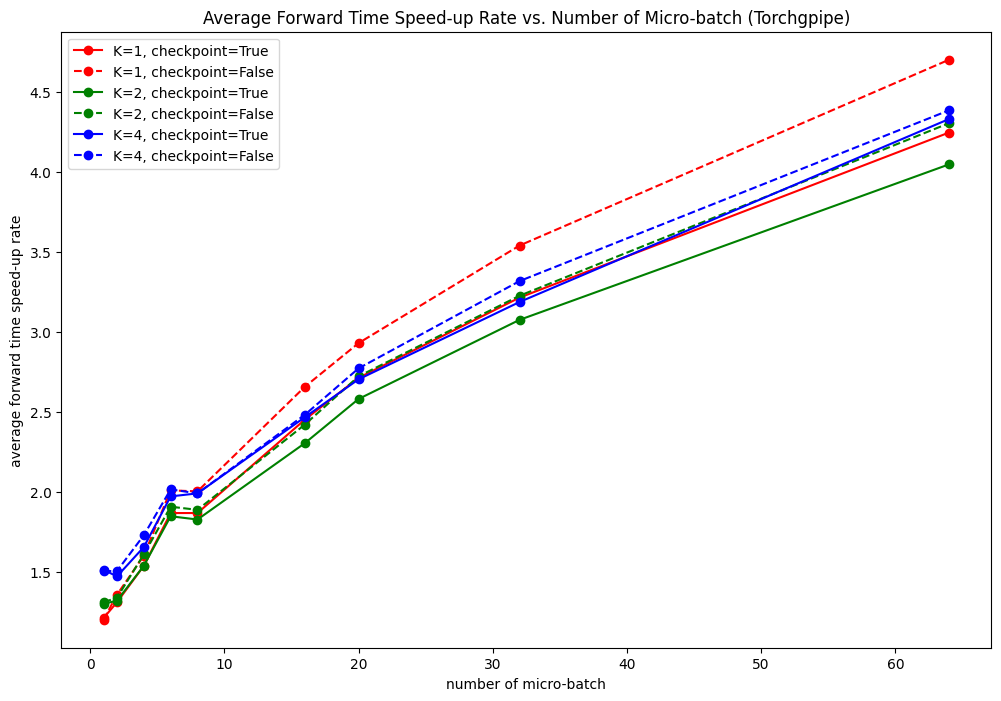

In [79]:
import math
colors = dict(zip(num_partitions, ['r', 'g', 'b']))
linestyles = dict(zip(checkpoint_enabled, ['-', '--']))
base_forward_time = baseline['average_forward_time_sec']
base_backward_time = baseline['average_backward_time_sec']

# Plot the average forward time speed-up rate compared to baseline 
fig = plt.figure(figsize=(12, 8))
for num_partition in num_partitions:
    for checkpoint in checkpoint_enabled:
        forward_time_speed_up = []
        for num_micro_batch in num_micro_batches:
            expr_name = args_to_exprname(
                num_partition, num_micro_batch, checkpoint, use_torchgpipe=True
            )
            data = expr_data[expr_name]
            forward_time_speed_up.append(data['average_forward_time_sec'] / base_forward_time)

        plt.plot(num_micro_batches, forward_time_speed_up,
            color=colors[num_partition], linestyle=linestyles[checkpoint],
            label=f'K={num_partition}, checkpoint={checkpoint}',
            marker='o',
        )
        plt.xlabel('number of micro-batch')
        plt.ylabel('average forward time speed-up rate')
        plt.title('Average Forward Time Speed-up Rate vs. Number of Micro-batch (Torchgpipe)')
        plt.legend()

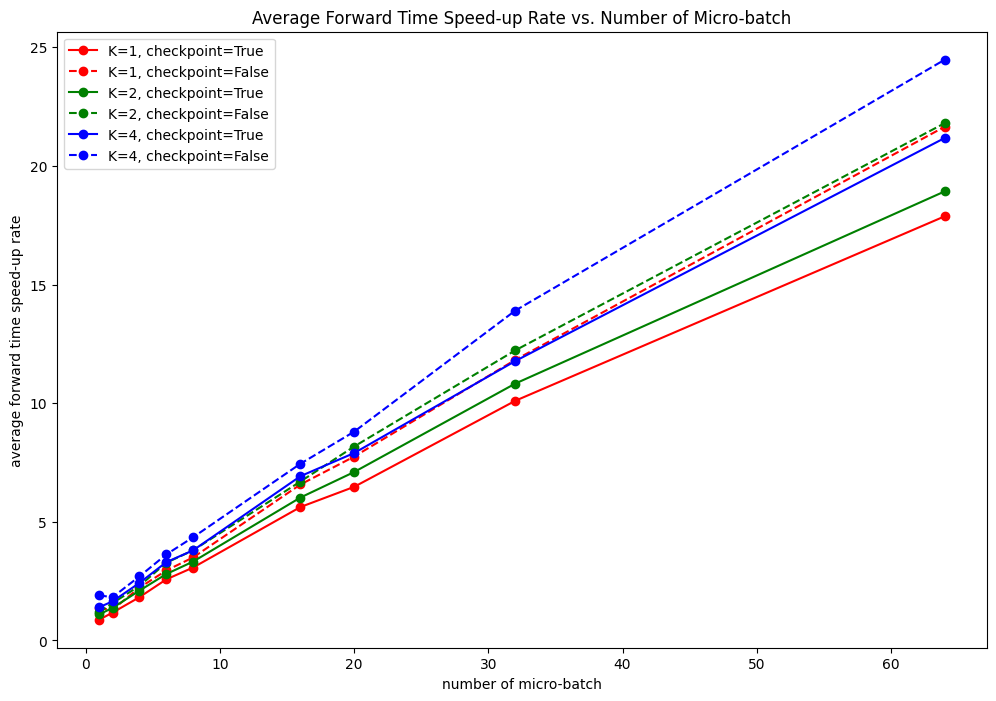

In [81]:
import math
colors = dict(zip(num_partitions, ['r', 'g', 'b']))
linestyles = dict(zip(checkpoint_enabled, ['-', '--']))
base_forward_time = baseline['average_forward_time_sec']
base_backward_time = baseline['average_backward_time_sec']

# Plot the average forward time speed-up rate compared to baseline 
fig = plt.figure(figsize=(12, 8))
for num_partition in num_partitions:
    for checkpoint in checkpoint_enabled:
        forward_time_speed_up = []
        for num_micro_batch in num_micro_batches:
            expr_name = args_to_exprname(
                num_partition, num_micro_batch, checkpoint, use_torchgpipe=False
            )
            data = expr_data[expr_name]
            forward_time_speed_up.append(data['average_forward_time_sec'] / base_forward_time)

        plt.plot(num_micro_batches, forward_time_speed_up,
            color=colors[num_partition], linestyle=linestyles[checkpoint],
            label=f'K={num_partition}, checkpoint={checkpoint}',
            marker='o',
        )
        plt.xlabel('number of micro-batch')
        plt.ylabel('average forward time speed-up rate')
        plt.title('Average Forward Time Speed-up Rate vs. Number of Micro-batch')
        plt.legend()

In [82]:
expr_data[args_to_exprname(
        2, 16, True, use_torchgpipe=True
    )]

{'peak_activation_memory_mib': 405.65,
 'total_memory_mib': 1004.0,
 'average_forward_time_sec': 0.213,
 'average_backward_time_sec': 0.302,
 'throughput_samples_per_sec': 248.316,
 'max_memory_per_device_mib': {'cuda:0': 362.0, 'cuda:1': 642.0}}